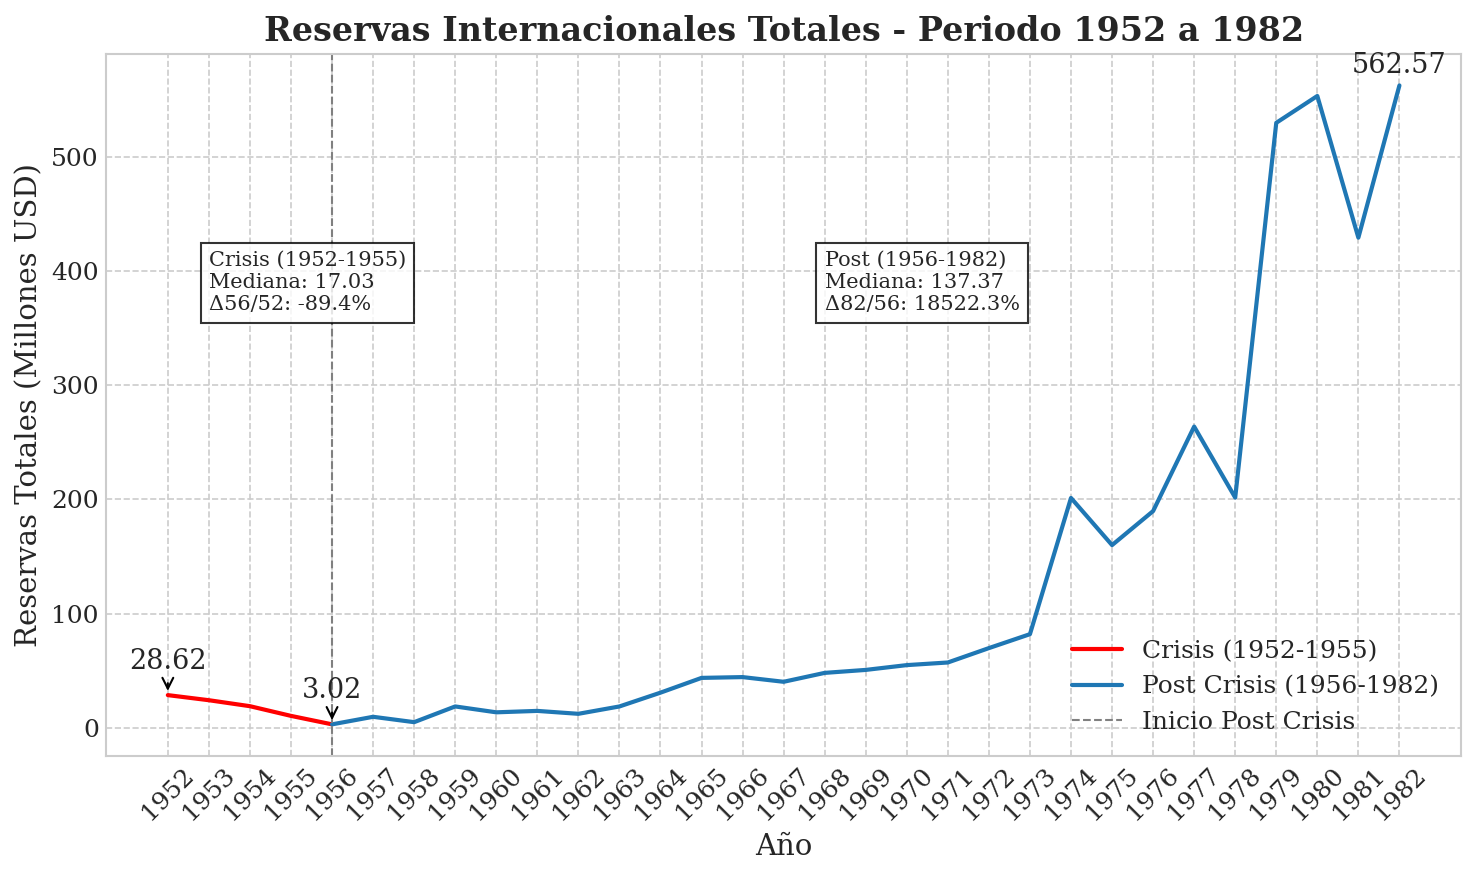

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import os
import seaborn as sns

def cuadro_estadisticas(serie):
    mean = serie.mean()
    g56  = (serie.loc[1956] - serie.loc[1952]) / serie.loc[1952] * 100
    return (f"Crisis (1952‑1955)\nMediana: {mean:.2f}\n"
            f"Δ56/52: {g56:.1f}%")

def cuadro_estadisticas_post(serie):
    mean = serie.loc[1956:1982].mean()
    g56  = 0                                 # ya es el punto inicial post‑crisis
    g82  = (serie.loc[1982] - serie.loc[1956]) / serie.loc[1956] * 100
    return (f"Post (1956‑1982)\nMediana: {mean:.2f}\n"
            f"Δ82/56: {g82:.1f}%")
# --- Configurar estilo profesional ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'figure.dpi': 150,
    'savefig.bbox': 'tight'
})

# --- Cargar datos desde SQLite ---
conn = sqlite3.connect('../../../db/proyectomacro.db')
df_reservas = pd.read_sql_query("SELECT * FROM Reservas_oro_divisas", conn)
conn.close()

# --- Preprocesamiento: Establecer el índice y recortar periodo ---
df_reservas.set_index('año', inplace=True)
df_reservas = df_reservas.loc[1952:1982]

# --- Segmentación en Pre y Post Crisis ---
df_pre = df_reservas.loc[1952:1956]
df_post = df_reservas.loc[1956:1982]
df_full = df_reservas  # Para anotaciones y cuadros


# --- Creación de la gráfica ---
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar segmento pre crisis en azul y post crisis en rojo
ax.plot(df_pre.index, df_pre['reservas_totales'], color='red', label='Crisis (1952-1955)')
ax.plot(df_post.index, df_post['reservas_totales'], color='#1f77b4', label='Post Crisis (1956-1982)')

# Línea separadora vertical en el año 1956
ax.axvline(x=1956, color='gray', linestyle='--', linewidth=1, label='Inicio Post Crisis')

# Anotaciones en años clave: 1952, 1956 y 1982
for year in [1952, 1956, 1982]:
    if year in df_full.index:
        value = df_full.loc[year, 'reservas_totales']
        if year == 1982:
            ax.annotate(f"{value:.2f}", xy=(year, value),
                        xytext=(year, value*1.02 ),
                        fontsize=13, ha='center')
        else:
            ax.annotate(f"{value:.2f}", xy=(year, value),
                        xytext=(year, value+23),
                        arrowprops=dict(facecolor='black', arrowstyle='->'),
                        fontsize=13, ha='center')

# Cuadros de estadísticas descriptivas
ax.text(1953, df_full['reservas_totales'].max() * 0.65, cuadro_estadisticas(df_pre['reservas_totales']),
        fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
ax.text(1968, df_full['reservas_totales'].max() * 0.65, cuadro_estadisticas_post(df_post['reservas_totales']),
        fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
 
# Etiquetas, título y leyenda
ax.set_title('Reservas Internacionales Totales - Periodo 1952 a 1982', fontweight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('Reservas Totales (Millones USD)')
ax.legend()

plt.xticks(df_reservas.index,rotation=45)
plt.tight_layout()

# --- Guardar la imagen en la ruta actualizada ---
output_dir = "../../../assets/tesis/intervensionismo_estatal/serie_completa"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.savefig(os.path.join(output_dir, "reservas.png"))
plt.show()
